In [2]:
dataverse_path='/Users/jessicasun/Desktop/research files/cones dataverse/data'

This notebook is for finding the misorientation across the grain boundary and plotting it against the cone angle. Data output in dataverse_path/data/all grains/orientation/full/grain

The final plots are made in 3_analysis.ipynb

In [6]:
# %%capture

import sys
import numpy as np
import pandas as pd
import os
import trackpy as tp
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib import cm
from skimage import io, exposure
from skimage.filters import threshold_otsu, threshold_multiotsu, try_all_threshold, threshold_local
from skimage.morphology import skeletonize, convex_hull_image
from skimage.measure import label, regionprops_table
from skimage.color import rgb2gray, gray2rgb
from scipy.ndimage import binary_opening, binary_closing, binary_erosion, binary_dilation, rotate, gaussian_filter
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.stats import circmean, sem, circstd
from scipy.interpolate import griddata

In [11]:
# def blockPrint():
#     sys.stdout = open(os.devnull, 'w')
# def enablePrint():
#     sys.stdout = sys.__stdout__
# blockPrint()
# #enablePrint()

In [12]:
dir_path=dataverse_path+'/'

files_df=pd.read_pickle(dir_path+'files_df.pkl')
files_df

print('find initial values and store in data_df')
px2um=0.0601936

coneangle_lim=[0,np.max(np.abs(files_df['coneangle']))]
sectorangle_lim=[0,np.max(np.abs(files_df['sectorangle']))]
bandwidth_lim=[0,np.max(files_df['band_width'])*px2um]
diam_lim=[np.min(files_df['band_diam_0'])*px2um,np.max(files_df['band_diam_0'])*px2um]

data_df=pd.DataFrame([])
data_df['coneangle']=np.abs(files_df['coneangle'])
data_df['sectorangle']=np.abs(files_df['sectorangle'])
data_df['band_width_um']=files_df['band_width']*px2um

data_df['coneangle_rad']=np.deg2rad(data_df['coneangle'])
data_df['sectorangle_rad']=np.deg2rad(data_df['sectorangle'])

#place all 0 with np.nan for the log columns
data_df[data_df==0]=np.nan
# data_df[data_df==0]=10**-10
data_df['log_coneangle_rad']=np.log(data_df['coneangle_rad'])
data_df['log_sectorangle_rad']=np.log(data_df['sectorangle_rad'])
data_df['log_width_um']=np.log(data_df['band_width_um'])

#reimport the main columns with full values
data_df['coneangle']=np.abs(files_df['coneangle'])
data_df['sectorangle']=np.abs(files_df['sectorangle'])
data_df['coneangle_rad']=np.deg2rad(data_df['coneangle'])
data_df['sectorangle_rad']=np.deg2rad(data_df['sectorangle'])
data_df['band_width_um']=files_df['band_width']*px2um
data_df['band_diam_um']=files_df['band_diam_0']*px2um

#dislocation spacing
a0=0.710 #where b = a0 burgers vector
data_df['dislocation_spacing']=a0/np.tan(data_df['sectorangle_rad']) #um

find initial values and store in data_df


highlight and show select points


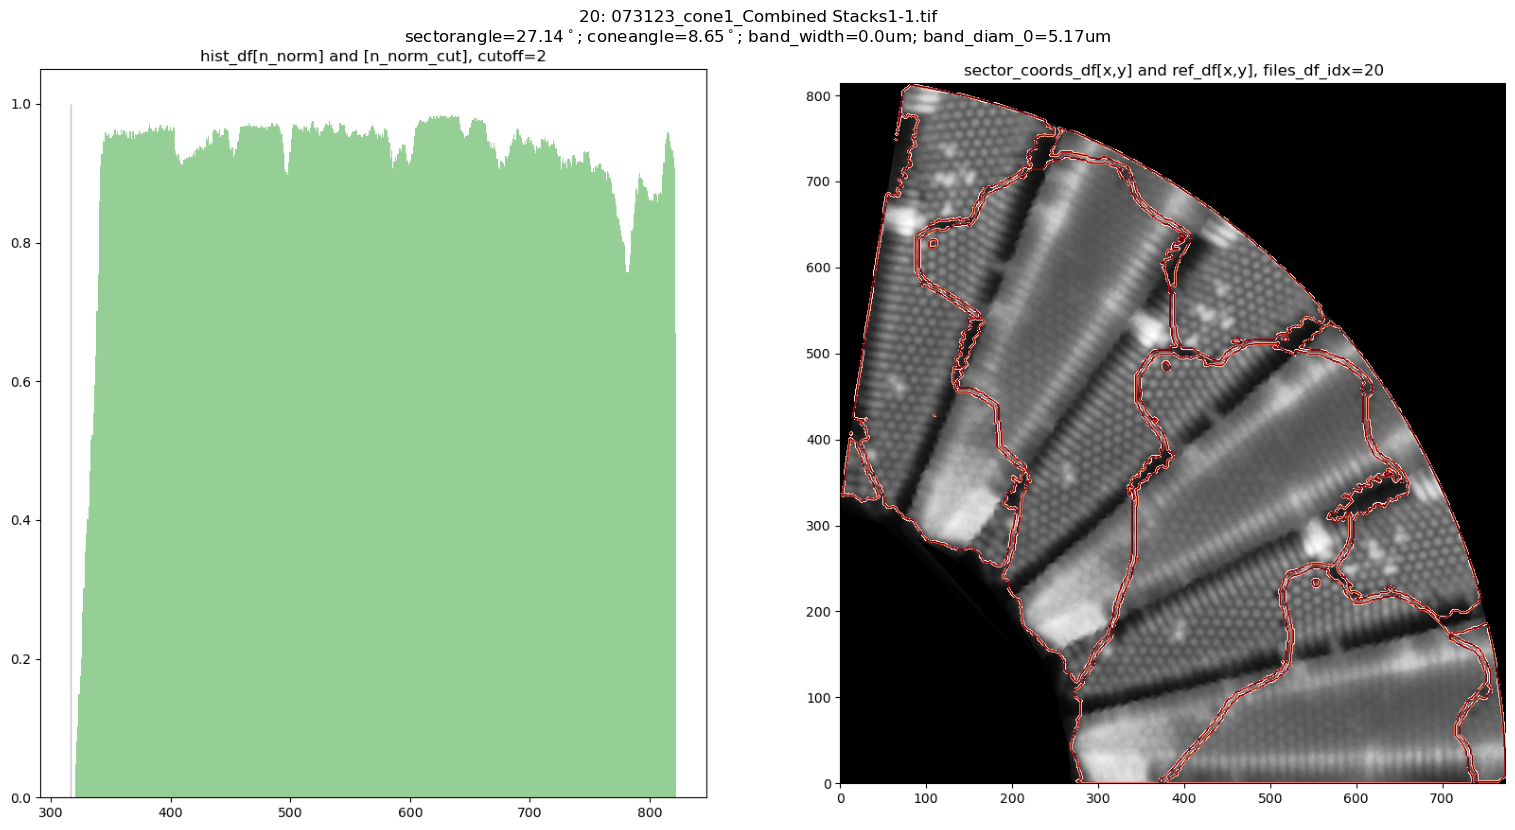

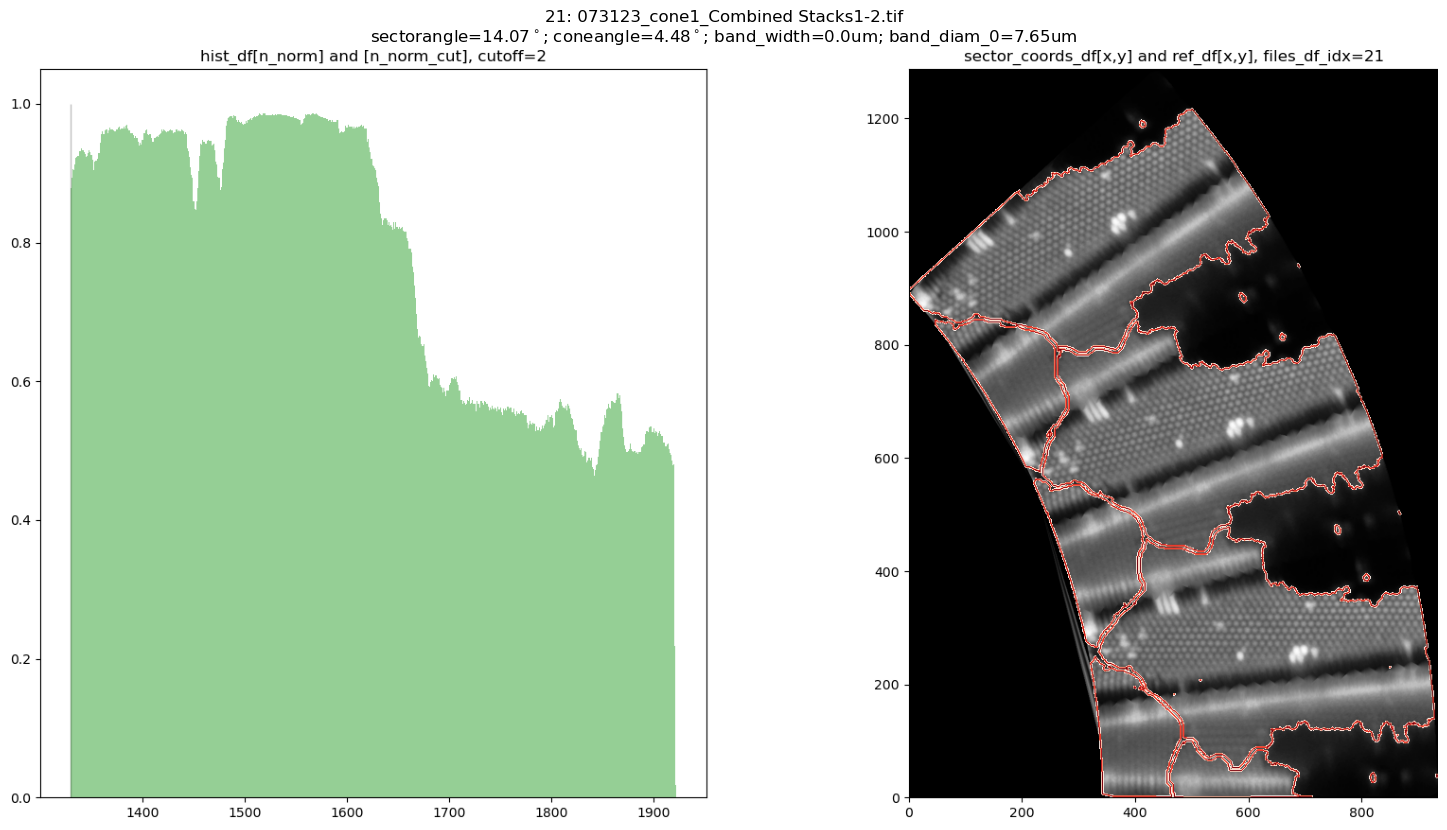

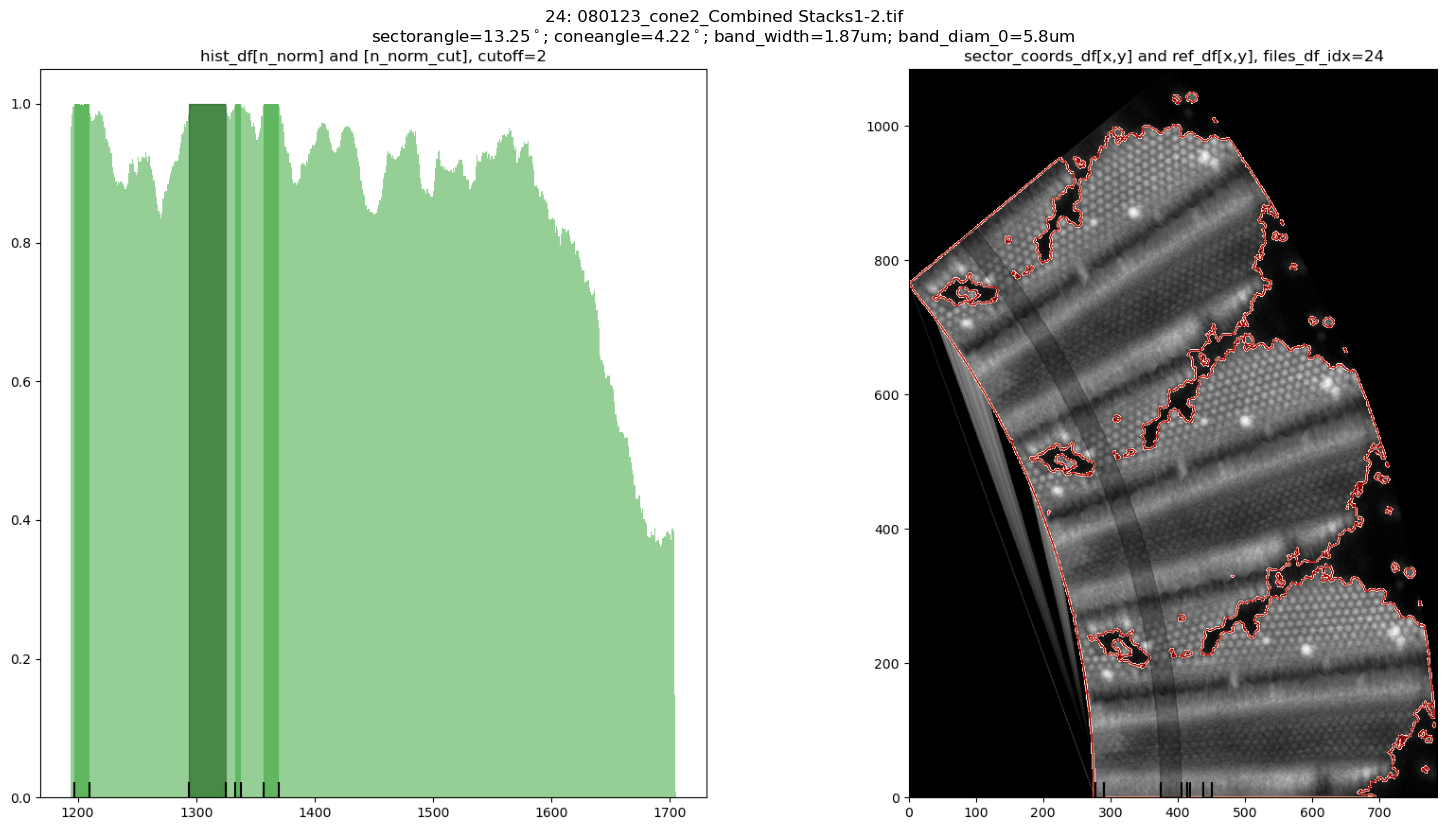

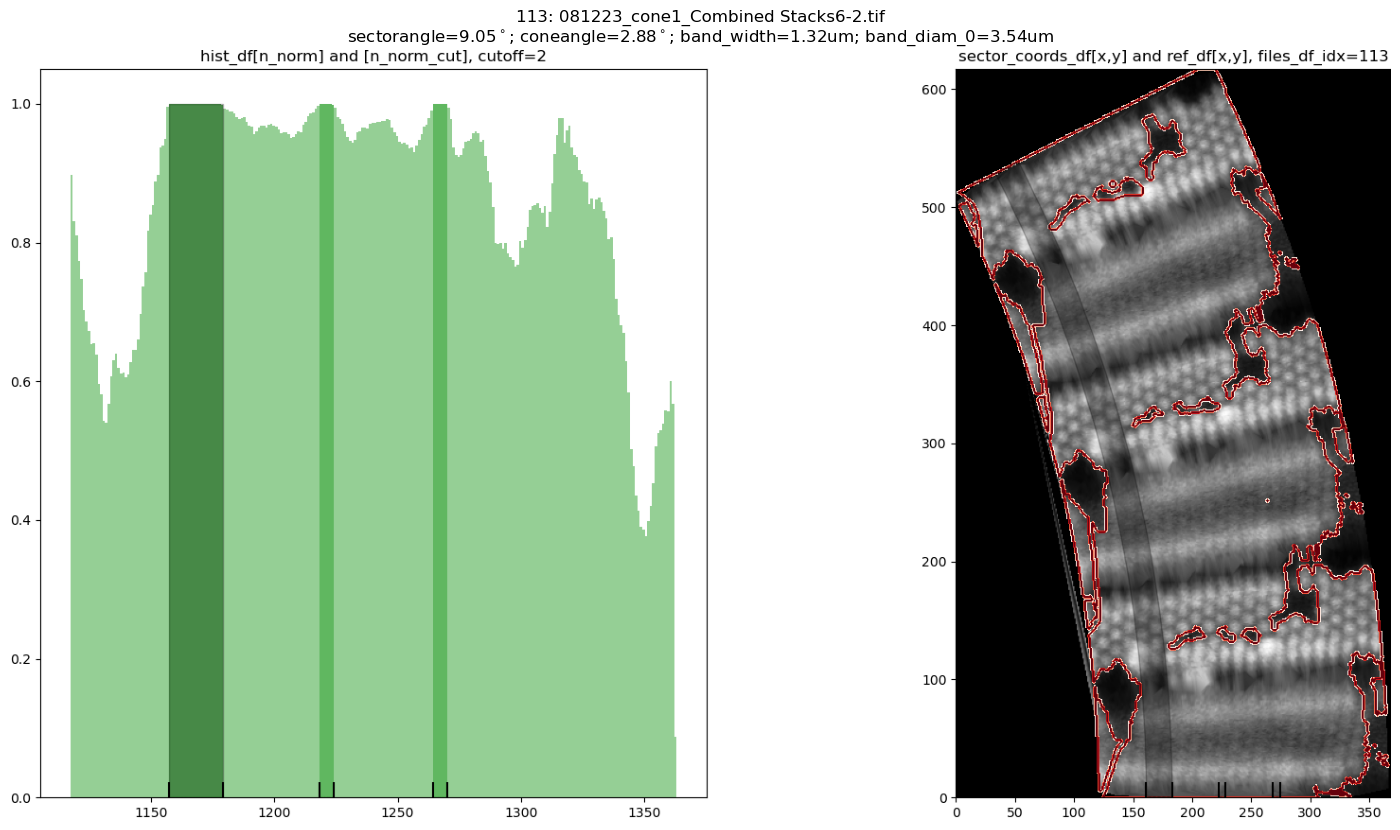

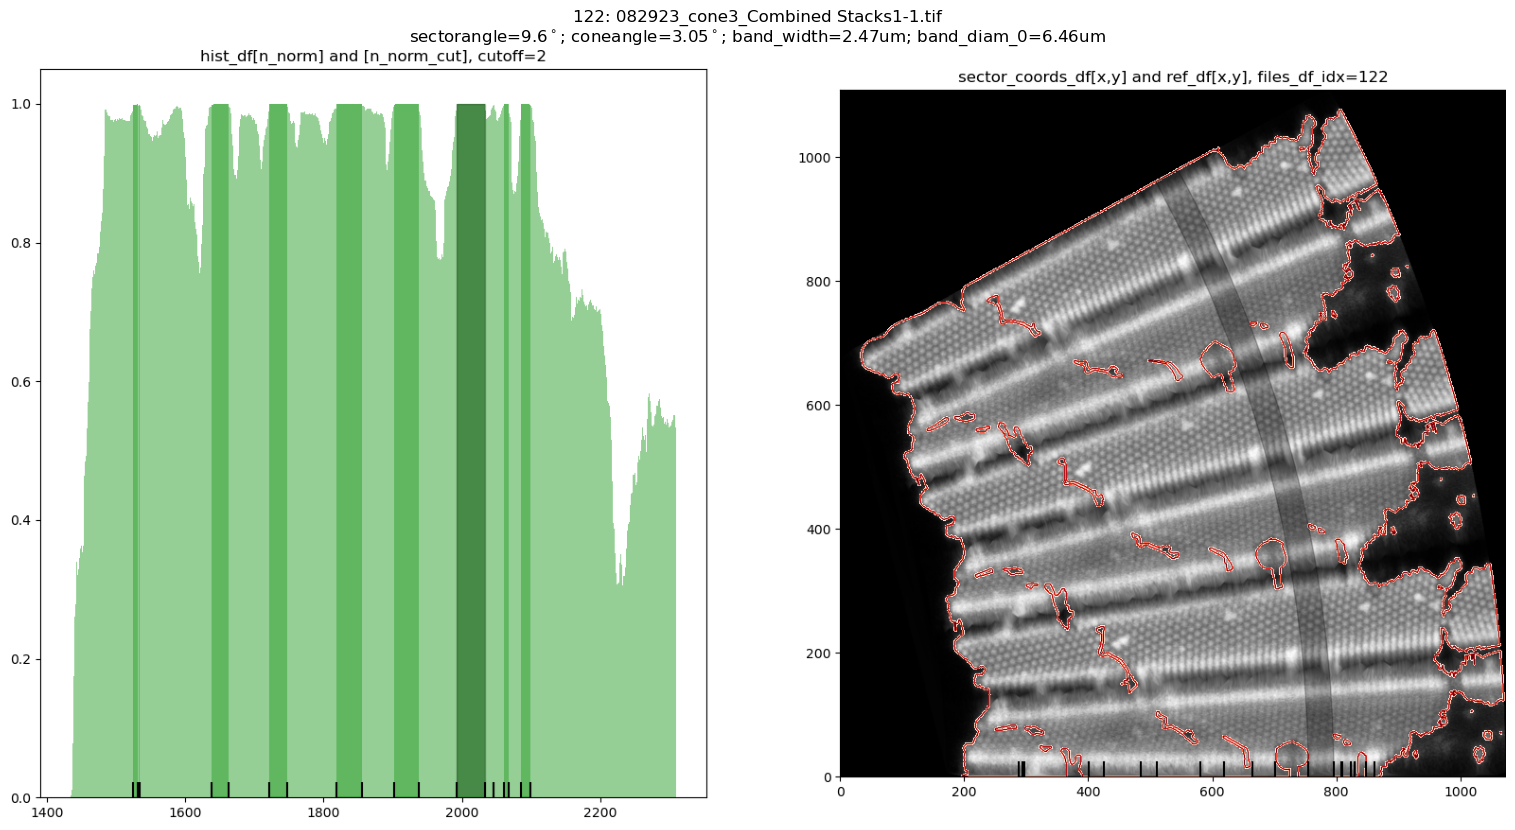

In [14]:
print('highlight and show select points')
# files_df_idx_list=data_df[data_df['coneangle']>=0].index.values
files_df_idx_list=[20, 21, 24, 113, 122] #indices with defined seams
filtered_x=[]
filtered_y=[]
filtered_c=[]
filtered_row_idx=[]
filtered_files_df_idx=[]
for files_df_idx in files_df_idx_list:
    im=io.imread(dir_path+'/all grains/bands/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png')    
    fig=plt.figure(figsize=(20,10))
    ax=fig.add_subplot(111)    
    ax.imshow(im)
    ax.set_title(str(files_df_idx)+': '+files_df['file_name'].iloc[files_df_idx]+'\n'
                 +'sectorangle='+str(round(np.abs(files_df['sectorangle'].iloc[files_df_idx]),2))+r'$^\circ$'+'; '
                 +'coneangle='+str(round(np.abs(files_df['coneangle'].iloc[files_df_idx]),2))+r'$^\circ$'+'; '                 
                 +'band_width='+str(round(files_df['band_width'].iloc[files_df_idx]*px2um,2))+'um; '
                 +'band_diam_0='+str(round(files_df['band_diam_0'].iloc[files_df_idx]*px2um,2))+'um')
    ax.axis('off')
    plt.show()
    filtered_x+=[np.abs(data_df['coneangle'].iloc[files_df_idx])]
    filtered_y+=[data_df['band_width_um'].iloc[files_df_idx]]
    filtered_c+=[data_df['band_diam_um'].iloc[files_df_idx]]
    filtered_row_idx+=[-100]
    filtered_files_df_idx+=[files_df_idx]
    
####
figsize_dim=(10,5)

For each files_df_idx of interest, (I've identified them to be: [20, 21, 24, 113, 122] which have a distinct self-boundary), find the misorientation across the seam. We'll need to manually select the grain 1 and grain 2 to find the misorientation.

input files_df_idx ([20, 21, 24, 113, 122]) 20


find im_top and im_bot using unwrapped image
find grain orientation


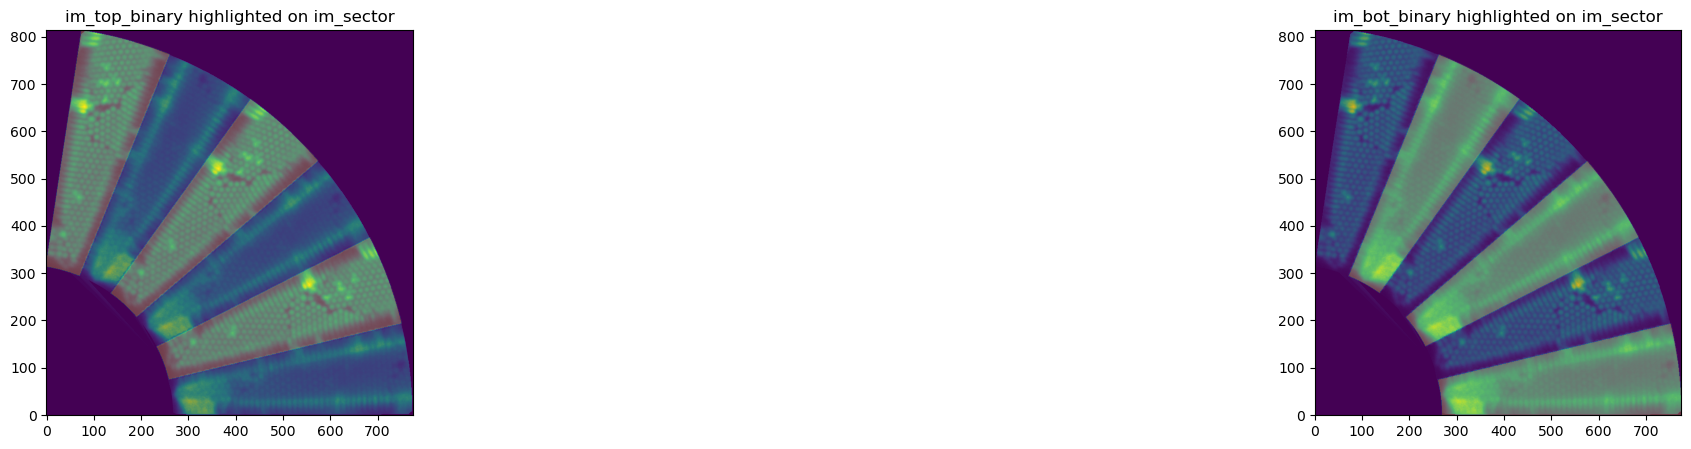

In [15]:
files_df_idx=int(input('input files_df_idx ([20, 21, 24, 113, 122])'))
print('find im_top and im_bot using unwrapped image')
im_sector=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.png'))
im_sector_binary=np.flipud(io.imread(dir_path+'/all grains/masked grains/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'.tif'))

origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']
ref_df=pd.DataFrame({'x':np.where(im_sector>=0)[1]-origin_x,'y':np.where(im_sector>=0)[0]-origin_y})
ref_df['sectorR']=np.sqrt(ref_df['x']**2+ref_df['y']**2)
ref_df['phi']=np.rad2deg(np.arctan2(ref_df['y'],ref_df['x']))

im_top_df=ref_df[(ref_df['phi']>=0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_top_df2=ref_df[(ref_df['phi']>=1.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_top_df3=ref_df[(ref_df['phi']>=2.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<3*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_top_df=pd.concat([im_top_df,im_top_df2,im_top_df3])

im_bot_df=ref_df[(ref_df['phi']>=0*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<0.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_bot_df2=ref_df[(ref_df['phi']>=1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<1.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_bot_df3=ref_df[(ref_df['phi']>=2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(ref_df['phi']<2.5*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period
                     &(ref_df['sectorR']>=(files_df['sectorR_min'].iloc[files_df_idx]))
                     &(ref_df['sectorR']<=(files_df['sectorR_max'].iloc[files_df_idx]))] #yes, band and bounds end up beign relevant
im_bot_df=pd.concat([im_bot_df,im_bot_df2,im_bot_df3])

origin_x=files_df.iloc[files_df_idx]['origin_x']
origin_y=files_df.iloc[files_df_idx]['origin_y']
im_top_binary=np.zeros(np.shape(im_sector))
for im_top_idx in range(len(im_top_df)):
    x=int(im_top_df.iloc[im_top_idx]['x']+origin_x)
    y=int(im_top_df.iloc[im_top_idx]['y']+origin_y)
    im_top_binary[y,x]=1
im_bot_binary=np.zeros(np.shape(im_sector))
for im_bot_idx in range(len(im_bot_df)):
    x=int(im_bot_df.iloc[im_bot_idx]['x']+origin_x)
    y=int(im_bot_df.iloc[im_bot_idx]['y']+origin_y)
    im_bot_binary[y,x]=1

fig=plt.figure(figsize=(figsize_dim[0]*3,figsize_dim[1]))
ax=fig.add_subplot(121)
ax.imshow(im_sector,origin='lower',alpha=1)
ax.imshow(im_top_binary,origin='lower',alpha=0.25)
ax.set_title('im_top_binary highlighted on im_sector')

ax=fig.add_subplot(122)
ax.imshow(im_sector,origin='lower',alpha=1)
ax.imshow(im_bot_binary,origin='lower',alpha=0.25)
ax.set_title('im_bot_binary highlighted on im_sector')

print('find grain orientation')
im_top=im_top_binary*im_sector

im_bot=exposure.equalize_adapthist(im_bot_binary.astype('bool')*im_sector,kernel_size=(5,5))

sharpen im_top and im_bot to help with particle tracking


Text(0.5, 1.0, 'im_bot, sharpened')

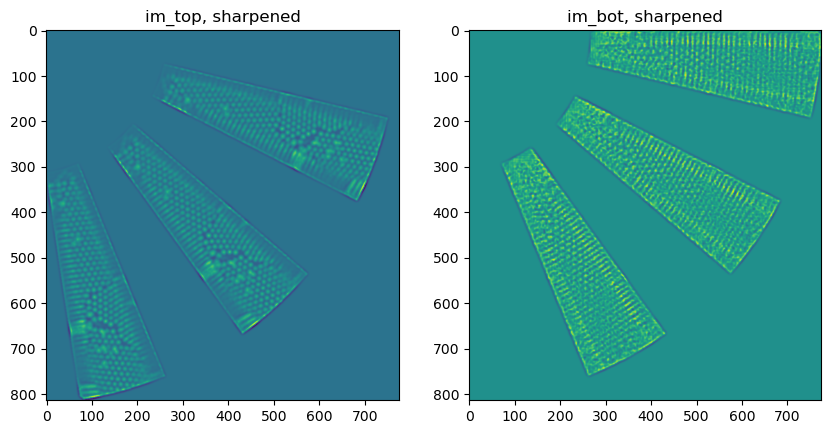

In [16]:
print('sharpen im_top and im_bot to help with particle tracking')
fig=plt.figure(figsize=(10,5))
f = im_top
blurred_f = gaussian_filter(f, 2)
filter_blurred_f = gaussian_filter(blurred_f, 1)
alpha = 100
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
im_top=sharpened
ax=fig.add_subplot(121)
ax.imshow(im_top)
ax.set_title('im_top, sharpened')

f = im_bot
blurred_f = gaussian_filter(f, 2)
filter_blurred_f = gaussian_filter(blurred_f, 1)
alpha = 100
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f) #unsharp masking ('linear sharpening')
im_bot=sharpened
ax=fig.add_subplot(122)
ax.imshow(im_bot)
ax.set_title('im_bot, sharpened')

find particles


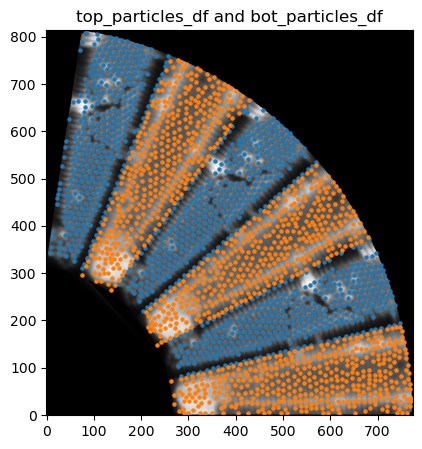

store particle positions as graph nodes
find bonds and add as edges to graph


In [17]:
print('find particles')
fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]))
ax=fig.add_subplot(121)
top_particles_df=tp.locate(im_top*im_top_binary,diameter=7,preprocess=False)
top_particles_df['pos']=list(zip(top_particles_df['x'],top_particles_df['y']))
ax.scatter(top_particles_df['x'],top_particles_df['y'],s=5)

bot_particles_df=tp.locate(im_bot*im_bot_binary,diameter=7,preprocess=False) #characterize=False,
# bot_particles_df=bot_particles_df[bot_particles_df['ecc']<0.1].reset_index(drop=True) #don't consider large&bright particles
bot_particles_df['pos']=list(zip(bot_particles_df['x'],bot_particles_df['y']))
ax.scatter(bot_particles_df['x'],bot_particles_df['y'],s=5)

ax.imshow(im_sector,cmap='Greys_r',alpha=1,origin='lower')
ax.set_title('top_particles_df and bot_particles_df')

plt.show()

print('store particle positions as graph nodes')
top_graph=nx.Graph()
node_list=[]
for node_idx in range(len(top_particles_df)):
    node_list+=[(node_idx,top_particles_df.T.to_dict()[node_idx])]
top_graph.add_nodes_from(node_list)

bot_graph=nx.Graph()
node_list=[]
for node_idx in range(len(bot_particles_df)):
    node_list+=[(node_idx,bot_particles_df.T.to_dict()[node_idx])]
bot_graph.add_nodes_from(node_list)

print('find bonds and add as edges to graph')
dist_bond=17
dist_df=pd.DataFrame(cdist(top_particles_df[['x','y']],top_particles_df[['x','y']]))
adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
top_graph.add_edges_from(edge_list)

dist_df=pd.DataFrame(cdist(bot_particles_df[['x','y']],bot_particles_df[['x','y']]))
adj_matrix=dist_df[dist_df<dist_bond]>0 #adjacency matrix representing bonds between particle indices
edge_list=list(zip(np.where(adj_matrix)[0],np.where(adj_matrix)[1]))
bot_graph.add_edges_from(edge_list)

In [18]:
print('find bond orientation for a given bond and set as edge attribute')
for edge in list(top_graph.edges):
    node_i,node_j=edge
    i_pos,j_pos=top_graph.nodes[node_i]['pos'],top_graph.nodes[node_j]['pos']    
    ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
    ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]
    top_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float
for edge in list(bot_graph.edges):
    node_i,node_j=edge
    i_pos,j_pos=bot_graph.nodes[node_i]['pos'],bot_graph.nodes[node_j]['pos']    
    ij_angle=np.array((np.arctan2(i_pos[1]-j_pos[1],i_pos[0]-j_pos[0])*180/np.pi)%60) #convert to np array so that it's indexable (next line)
    ij_angle[ij_angle>30] -= 60 #shift from [0,60] to [-30,30]    
    bot_graph.edges[node_i,node_j]['ij_angle']=float(ij_angle) #store as float

print('find ij_angle_avg (avg angle of all bonds) and set as graph attribute')
top_edge_df=nx.to_pandas_edgelist(top_graph)
ij_angle_avg=np.rad2deg(circmean(np.deg2rad(top_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
top_graph.graph['ij_angle_avg']=ij_angle_avg

bot_edge_df=nx.to_pandas_edgelist(bot_graph)
ij_angle_avg=np.rad2deg(circmean(np.deg2rad(bot_edge_df['ij_angle']),high=30*np.pi/180, low=-30*np.pi/180))
bot_graph.graph['ij_angle_avg']=ij_angle_avg


find bond orientation for a given bond and set as edge attribute
find ij_angle_avg (avg angle of all bonds) and set as graph attribute


In [19]:
print('find local orientation node_ij_avg (theta6 value at each node), and psi6, and set as node attribute')
edge_list=nx.to_pandas_edgelist(top_graph)
bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
    node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
    psi6_list=[]
    for angle in node_ij_angle:
        psi6_list+=[np.exp(1j*6*np.deg2rad(angle))]
    coordnum=len(psi6_list)
    psi6=np.abs(np.sum(psi6_list)/coordnum) #magnitude of complex number
    node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
    top_graph.nodes[node]['node_ij_avg'] = node_ij_avg
    top_graph.nodes[node]['psi6'] = psi6    
    top_graph.nodes[node]['coordnum'] = coordnum            
not_bonded_nodes_top=list(set(top_graph.nodes) - set(bonded_nodes)) #nodes without bonds
for node in not_bonded_nodes_top:
    top_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later
    top_graph.nodes[node]['psi6'] = -100 #set as placeholder angle, otherwise error thrown later        
    top_graph.nodes[node]['coordnum'] = -100 #set as placeholder angle, otherwise error thrown later                

edge_list=nx.to_pandas_edgelist(bot_graph)
bonded_nodes=np.unique(edge_list[['source','target']]) #nodes with bonds
for node in bonded_nodes: #note: nx.graph doesn't allow duplicate edges!
    node_ij_angle=list(edge_list[edge_list['source']==node]['ij_angle'].values)+list(edge_list[edge_list['target']==node]['ij_angle'].values) #find edges associated with a given node
    psi6_list=[]
    for angle in node_ij_angle:
        psi6_list+=[np.exp(1j*6*np.deg2rad(angle))]
    coordnum=len(psi6_list)            
    psi6=np.abs(np.sum(psi6_list)/coordnum) #magnitude of complex number        
    node_ij_avg=np.rad2deg(circmean(np.deg2rad(np.array(node_ij_angle)),high=30*np.pi/180, low=-30*np.pi/180)) #find avg of ij_angle for the edges around a node
    bot_graph.nodes[node]['node_ij_avg'] = node_ij_avg
    bot_graph.nodes[node]['psi6'] = psi6                
    bot_graph.nodes[node]['coordnum'] = coordnum                        
not_bonded_nodes_bot=list(set(bot_graph.nodes) - set(bonded_nodes)) #nodes without bonds
for node in not_bonded_nodes_bot:
    bot_graph.nodes[node]['node_ij_avg'] = -100 #set as placeholder angle, otherwise error thrown later
    bot_graph.nodes[node]['psi6'] = -100 #set as placeholder angle, otherwise error thrown later        
    bot_graph.nodes[node]['coordnum'] = -100 #set as placeholder angle, otherwise error thrown later                

print('convert to dataframe')
top_particles_df=pd.DataFrame.from_dict(top_graph.nodes, orient='index') 
bot_particles_df=pd.DataFrame.from_dict(bot_graph.nodes, orient='index')  


find local orientation node_ij_avg (theta6 value at each node), and psi6, and set as node attribute
convert to dataframe


draw graph nodes and edges
orientation histogram for visualization
colorbar for visualization

export files_df to store data info


date   cone              pullparams  \
20  073123  cone1  tw120_h448_p40_v20_t30   

                              file_name  \
20  073123_cone1_Combined Stacks1-1.tif   

                                            file_path  coneangle  line1angle  \
20  /Users/jessicasun/Desktop/research files/cones...   8.646798    4.028033   

    line2angle  line1slope  line2slope  ...  origin_y  band_width  \
20   -4.618765    0.070418   -0.080788  ...      -0.0         0.0   

    band_sectorR_min  band_sectorR_max  band_sectorR_0  band_area  \
20        316.580524        823.028444      569.804484        0.0   

    band_area_ref  band_circ_0  band_diam_0  band_label_cut  
20            0.0   269.895842    85.910515             NaN  

[1 rows x 45 columns]

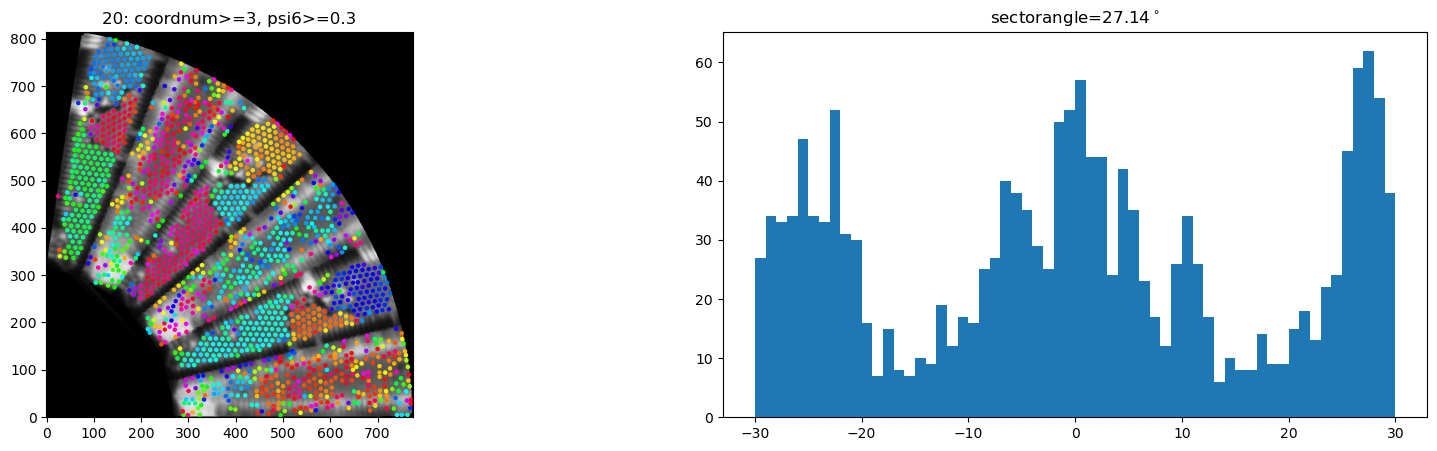

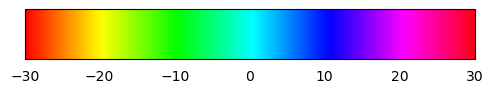

In [22]:
print('draw graph nodes and edges') #plot using dataframe - cant find edge colors anymore, but much simpler to filter particles
fig=plt.figure(figsize=(figsize_dim[0]*2,figsize_dim[1]))
ax=fig.add_subplot(121)
ax.imshow(im_sector,cmap='Greys_r',origin='lower')

particles_df=pd.concat([top_particles_df,bot_particles_df])
particles_df=particles_df[(particles_df['coordnum']>=3)&(particles_df['psi6']>=0.3)]
ax.scatter(particles_df['x'],particles_df['y'],c=particles_df['node_ij_avg'],vmin=-30,vmax=30,cmap='hsv',s=5)
ax.set_title(str(files_df_idx)+': coordnum>=3, psi6>=0.3')

print('orientation histogram for visualization')
# fig=plt.figure(figsize=(figsize_dim[0]*4,figsize_dim[1]/2))
ax=fig.add_subplot(122)
ax.hist(particles_df['node_ij_avg'],bins=np.arange(-30,31,1))    
# ax.hist(pd.concat([nx.to_pandas_edgelist(top_graph)['ij_angle'],nx.to_pandas_edgelist(bot_graph)['ij_angle']]),bins=np.arange(-30,30,5))
# ax.axvline(top_graph.graph['ij_angle_avg'],color='k')
ax.set_title('sectorangle='+str(round(files_df['sectorangle'].iloc[files_df_idx],2))+r'$^\circ$')

if not os.path.exists(dir_path+'/all grains/orientation/full'):
    os.mkdir(dir_path+'/all grains/orientation/full')
im_path=dir_path+'/all grains/orientation/full/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]+'_filtered'+'.png'
# io.imsave(im_path,(255*im_sector[:,:,0]/np.max(im_sector[:,:,0])).astype(np.uint8))    
plt.savefig(im_path,bbox_inches='tight', pad_inches=0)

print('colorbar for visualization')
fig=plt.figure(figsize=(5,5))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
norm=colors.Normalize(vmin=-30, vmax=30)
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='hsv'),cax=ax,orientation='horizontal')
plt.tick_params(bottom = False)

files_df.at[files_df_idx,'top_ij_angle_avg']=top_graph.graph['ij_angle_avg']
files_df.at[files_df_idx,'bot_ij_angle_avg']=bot_graph.graph['ij_angle_avg']

print('\nexport files_df to store data info')
files_df.to_pickle(dir_path+'files_df.pkl');
files_df.to_excel(dir_path+'/files_df.xlsx')

files_df.iloc[[files_df_idx]]

manually filter particles to get grains
find bounds for grain 1 and grain 2, where [left,right]=[0,1] * x-axis, and [bottom,top]=[0,1] * sector angle


left1 bound (0.4 for files_df_idx=20) 0.4
right1 bound (0.55 for files_df_idx=20) 0.55
bot1 bound (0.6 for files_df_idx=20) 0.6
top1 bound (1.0 for files_df_idx=20) 1
left2 bound (0.55 for files_df_idx=20) 0.55
right2 bound (0.7 for files_df_idx=20) 0.7
bot2 bound (0.5 for files_df_idx=20) 0.5
top2 bound (0.8 for files_df_idx=20) 0.8



 0.4 0.55 0.6 1.0 0.55 0.7 0.5 0.8


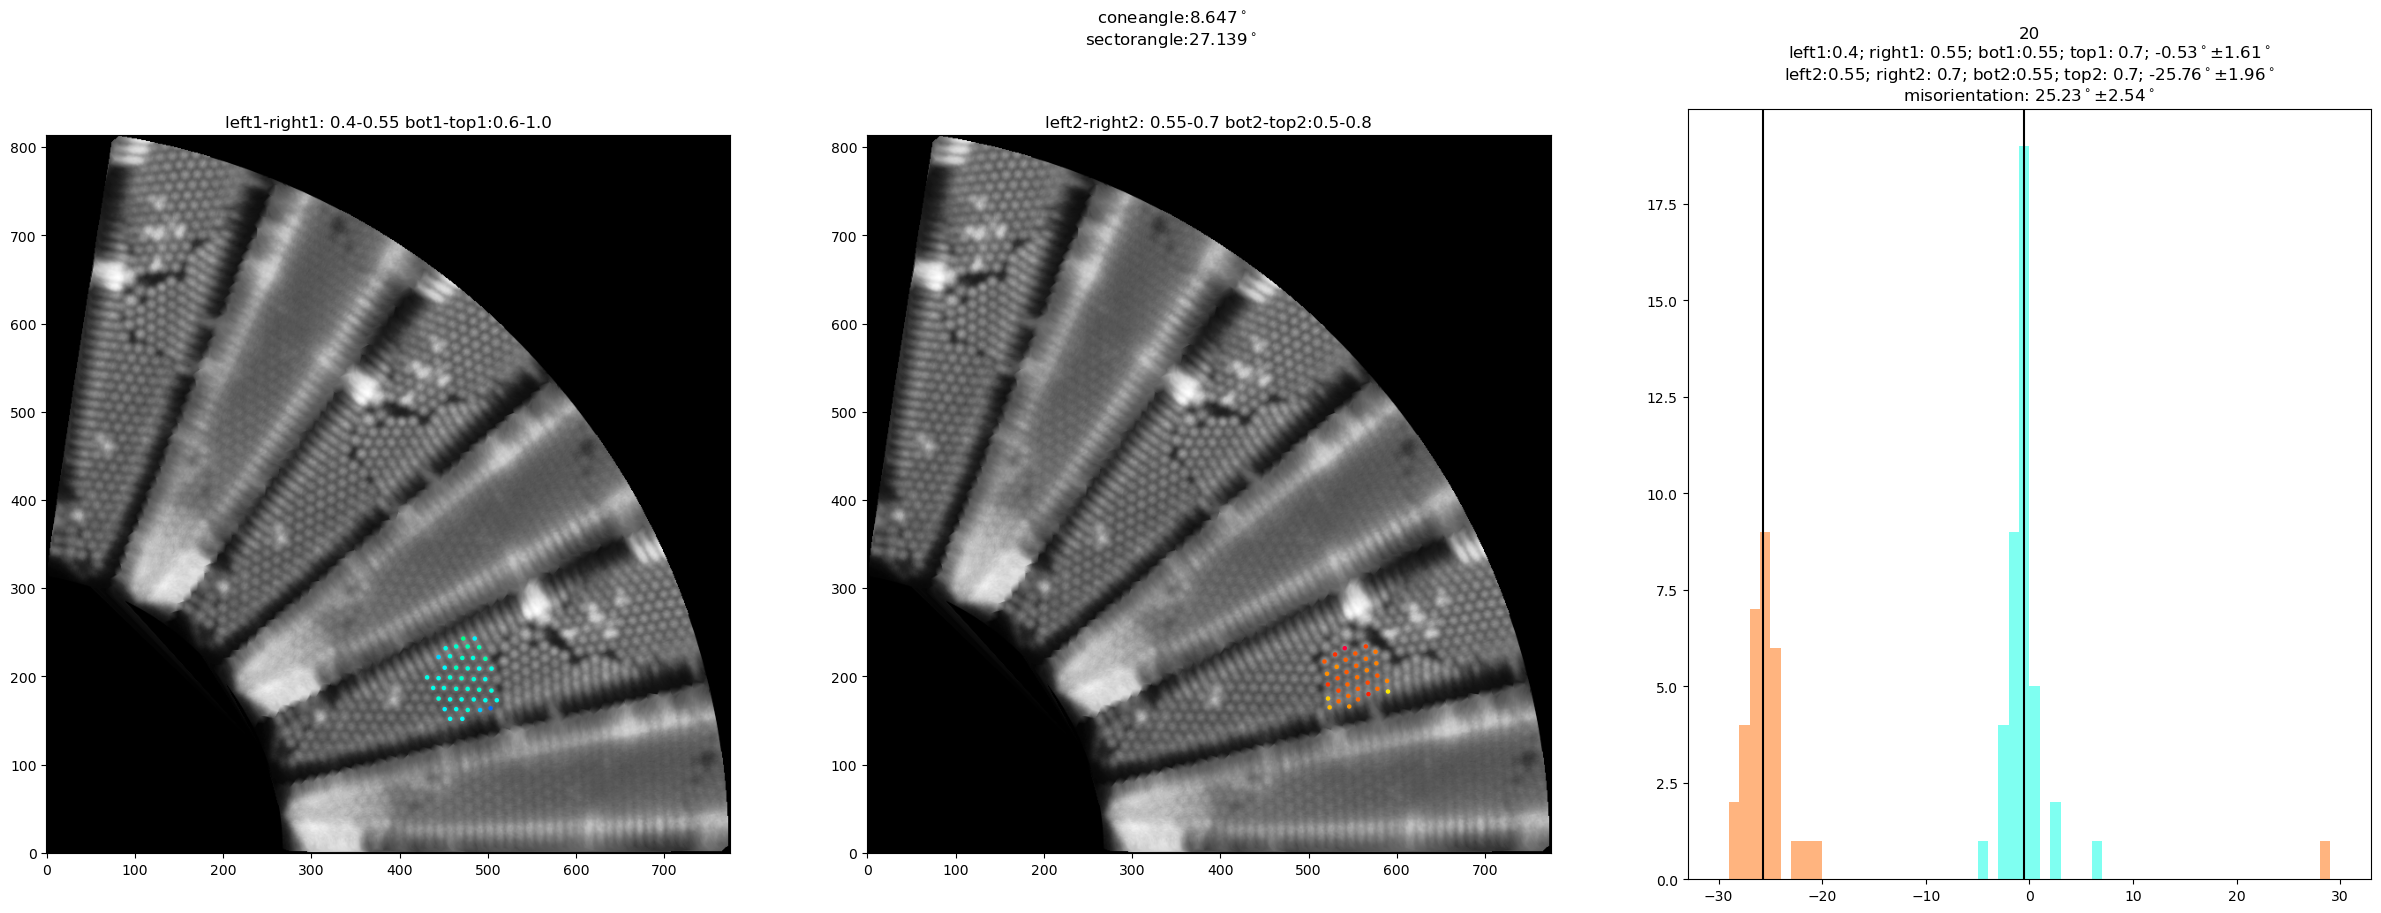

In [23]:
print('manually filter particles to get grains')
fig=plt.figure(figsize=(30,10))
ax=fig.add_subplot(131)
particles_df['x_shift']=particles_df['x']-origin_x
particles_df['y_shift']=particles_df['y']-origin_y
particles_df['sectorR']=np.sqrt(particles_df['x_shift']**2+particles_df['y_shift']**2)
particles_df['phi']=np.rad2deg(np.arctan2(particles_df['y_shift'],particles_df['x_shift']))

print('find bounds for grain 1 and grain 2, where [left,right]=[0,1] * x-axis, and [bottom,top]=[0,1] * sector angle')

if files_df_idx==122:
    left1_print='(0 for files_df_idx=122)'
    right1_print='(0.3 for files_df_idx=122)'
    bot1_print='(0.5 for files_df_idx=122)'
    top1_print='(1 for files_df_idx=122)'
    
    left2_print='(0.3 for files_df_idx=122)'
    right2_print='(0.9 for files_df_idx=122)'
    bot2_print='(0.5 for files_df_idx=122)'
    top2_print='(1 for files_df_idx=122)'
if files_df_idx==113:
    left1_print='(0.2 for files_df_idx=113)'
    right1_print='(0.5 for files_df_idx=113)'
    bot1_print='(0.5 for files_df_idx=113)'
    top1_print='(0.7 for files_df_idx=113)'
    
    left2_print='(0.2 for files_df_idx=113)'
    right2_print='(0.6 for files_df_idx=113)'
    bot2_print='(0.75 for files_df_idx=113)'
    top2_print='(0.9 for files_df_idx=113)'    
if files_df_idx==24:
    left1_print='(0.2 for files_df_idx=24)'
    right1_print='(0.5 for files_df_idx=24)'
    bot1_print='(0.5 for files_df_idx=24)'
    top1_print='(0.65 for files_df_idx=24)'

    left2_print='(0.2 for files_df_idx=24)'
    right2_print='(0.4 for files_df_idx=24)'
    bot2_print='(0.7 for files_df_idx=24)'
    top2_print='(1 for files_df_idx=24)'        
if files_df_idx==21:
    left1_print='(0.25 for files_df_idx=21)'
    right1_print='(0.5 for files_df_idx=21)'
    bot1_print='(1.1 for files_df_idx=21)'
    top1_print='(1.22 for files_df_idx=21)'

    left2_print='(0.25 for files_df_idx=21)'
    right2_print='(0.5 for files_df_idx=21)'
    bot2_print='(1.25 for files_df_idx=21)'
    top2_print='(1.4 for files_df_idx=21)'  
if files_df_idx==20:
    left1_print='(0.4 for files_df_idx=20)'
    right1_print='(0.55 for files_df_idx=20)'
    bot1_print='(0.6 for files_df_idx=20)'
    top1_print='(1.0 for files_df_idx=20)'

    left2_print='(0.55 for files_df_idx=20)'
    right2_print='(0.7 for files_df_idx=20)'
    bot2_print='(0.5 for files_df_idx=20)'
    top2_print='(0.8 for files_df_idx=20)'       
if files_df_idx not in [122,113,24,21,20]:
    left1_print='(0 for files_df_idx=122)'
    right1_print='(0.3 for files_df_idx=122)'
    bot1_print='(0.5 for files_df_idx=122)'
    top1_print='(1 for files_df_idx=122)'

    left2_print='(0.3 for files_df_idx=122)'
    right2_print='(0.9 for files_df_idx=122)'
    bot2_print='(0.5 for files_df_idx=122)'
    top2_print='(1 for files_df_idx=122)'

left1=float(input('left1 bound '+left1_print))
right1=float(input('right1 bound '+right1_print))
bot1=float(input('bot1 bound '+bot1_print))
top1=float(input('top1 bound '+top1_print))

axial_length=(files_df['sectorR_max'].iloc[files_df_idx])-(files_df['sectorR_min'].iloc[files_df_idx])
axial_min=files_df['sectorR_min'].iloc[files_df_idx]
filtered_df1=particles_df[(particles_df['phi']>=bot1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(particles_df['phi']<top1*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period. 0.5 to 1 is top half
                     &(particles_df['sectorR']>=left1*axial_length+axial_min)
                     &(particles_df['sectorR']<=right1*axial_length+axial_min)] #yes, band and bounds end up beign relevant
ax.imshow(im_sector,origin='lower',cmap='Greys_r')
# plt.scatter(particles_df['x'],particles_df['y'],c=particles_df['node_ij_avg'],cmap='hsv',s=5)
ax.set_title('left1-right1: '+str(left1)+'-'+str(right1)+' bot1-top1:'+str(bot1)+'-'+str(top1))
ax.scatter(filtered_df1['x'],filtered_df1['y'],c=filtered_df1['node_ij_avg'],cmap='hsv',s=5,vmin=-30,vmax=30)   

ax=fig.add_subplot(132)
left2=float(input('left2 bound '+left2_print))
right2=float(input('right2 bound '+right2_print))
bot2=float(input('bot2 bound '+bot2_print))
top2=float(input('top2 bound '+top2_print))

print('\n',left1,right1,bot1,top1,left2,right2,bot2,top2)

axial_length=(files_df['sectorR_max'].iloc[files_df_idx])-(files_df['sectorR_min'].iloc[files_df_idx])
axial_min=files_df['sectorR_min'].iloc[files_df_idx]
filtered_df2=particles_df[(particles_df['phi']>=bot2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #select absolute data bounds
                     &(particles_df['phi']<top2*np.abs(files_df['sectorangle'].iloc[files_df_idx])) #0 to 3 is entire region; 0 to 1 is one period. 0.5 to 1 is top half
                     &(particles_df['sectorR']>=left2*axial_length+axial_min)
                     &(particles_df['sectorR']<=right2*axial_length+axial_min)] #yes, band and bounds end up beign relevant
ax.imshow(im_sector,origin='lower',cmap='Greys_r')
# plt.scatter(particles_df['x'],particles_df['y'],c=particles_df['node_ij_avg'],cmap='hsv',s=5)
ax.set_title('left2-right2: '+str(left2)+'-'+str(right2)+' bot2-top2:'+str(bot2)+'-'+str(top2))    
ax.scatter(filtered_df2['x'],filtered_df2['y'],c=filtered_df2['node_ij_avg'],cmap='hsv',s=5,vmin=-30,vmax=30)

ax=fig.add_subplot(133)
mean1=circmean(filtered_df1['node_ij_avg'],low=-30,high=30)
std1=circstd(filtered_df1['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean1))    
ax.hist(filtered_df1['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
ax.axvline(x=mean1,color='k')    
# ax.set_title('left1:'+str(left1)+'; right1: '+str(right1)+'; '+str(round(mean1,2))+r'$^\circ$') 

mean2=circmean(filtered_df2['node_ij_avg'],low=-30,high=30)
std2=circstd(filtered_df2['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean2))    
ax.hist(filtered_df2['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
ax.axvline(x=mean2,color='k')    

ax.set_title(str(files_df_idx)+'\n'+'left1:'+str(left1)+'; right1: '+str(right1)+'; '+'bot1:'+str(left2)+'; top1: '+str(right2)+'; '+str(round(mean1,2))+r'$^\circ$'+r'$\pm$'+str(round(std1,2))+r'$^\circ$'+'\n'+    
             'left2:'+str(left2)+'; right2: '+str(right2)+'; '+'bot2:'+str(left2)+'; top2: '+str(right2)+'; '+str(round(mean2,2))+r'$^\circ$'+r'$\pm$'+str(round(std2,2))+r'$^\circ$'+'\n'+           
            'misorientation: '+str(round(np.abs(mean2-mean1),2))+r'$^\circ$'+r'$\pm$'+str(round(np.sqrt(std1**2+std2**2),2))+r'$^\circ$')   
fig.suptitle('coneangle:'+str(round(files_df.iloc[files_df_idx]['coneangle'],3))+r'$^\circ$'+'\n'+
             'sectorangle:'+str(round(files_df.iloc[files_df_idx]['sectorangle'],3))+r'$^\circ$')
if not os.path.exists(dir_path+'/all grains/orientation/full/grain'):
    os.mkdir(dir_path+'/all grains/orientation/full/grain')
im_path=dir_path+'/all grains/orientation/full/grain/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]    
plt.savefig(im_path+'_summary.png',bbox_inches='tight', pad_inches=0) #+'_L'+str(left1)+'-'+str(left2)+'_R'+str(right1)+'-'+str(right2)+'_B'+str(bot1)+'-'+str(bot2)+'_T'+str(top1)+str(top2)

filtered_df1.to_pickle(im_path+'_1.pkl');    
filtered_df2.to_pickle(im_path+'_2.pkl');        

manually filter particles to get grains


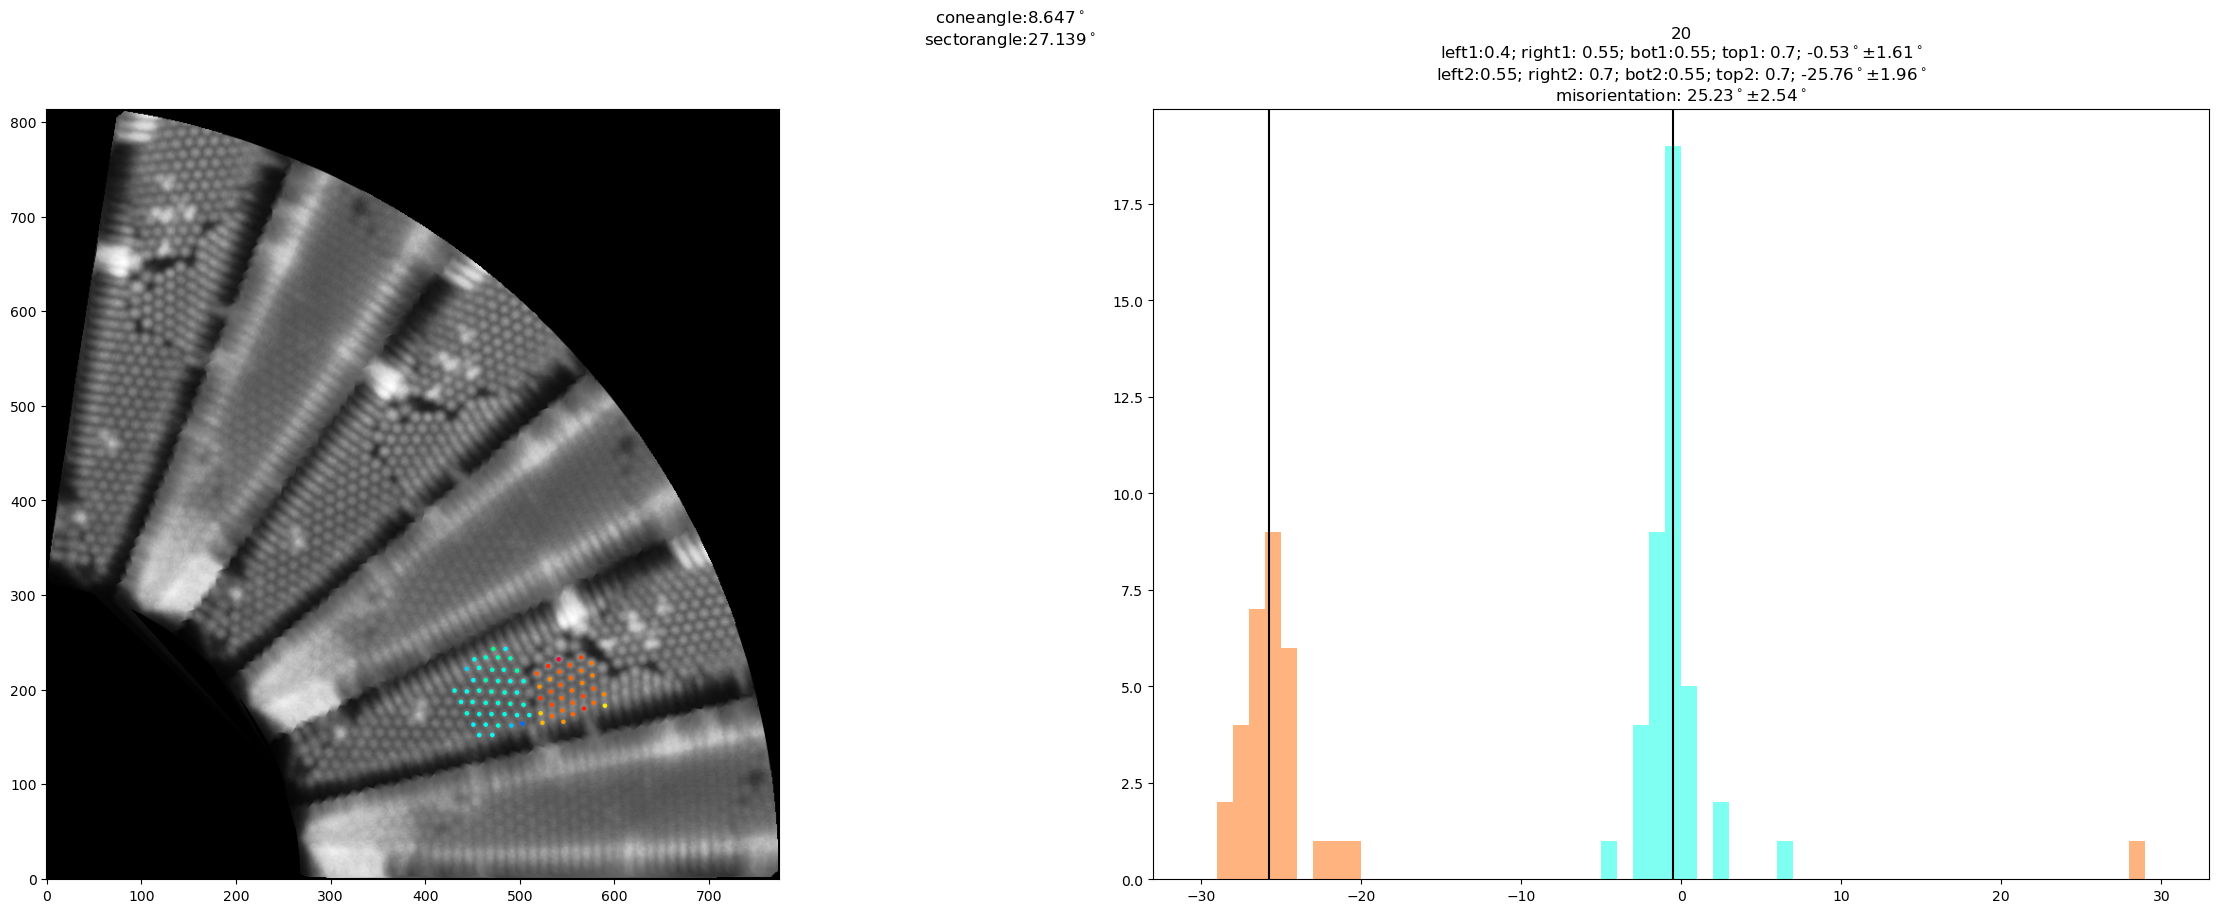

In [24]:
print('manually filter particles to get grains')
fig=plt.figure(figsize=(30,10))
ax=fig.add_subplot(121)

ax.imshow(im_sector,origin='lower',cmap='Greys_r')

ax.scatter(filtered_df1['x'],filtered_df1['y'],c=filtered_df1['node_ij_avg'],cmap='hsv',s=5,vmin=-30,vmax=30)   
ax.scatter(filtered_df2['x'],filtered_df2['y'],c=filtered_df2['node_ij_avg'],cmap='hsv',s=5,vmin=-30,vmax=30)

ax=fig.add_subplot(122)
mean1=circmean(filtered_df1['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean1))    
ax.hist(filtered_df1['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
ax.axvline(x=mean1,color='k')    
# ax.set_title('left1:'+str(left1)+'; right1: '+str(right1)+'; '+str(round(mean1,2))+r'$^\circ$') 

mean2=circmean(filtered_df2['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean2))    
ax.hist(filtered_df2['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
ax.axvline(x=mean2,color='k')    

ax.set_title(str(files_df_idx)+'\n'+'left1:'+str(left1)+'; right1: '+str(right1)+'; '+'bot1:'+str(left2)+'; top1: '+str(right2)+'; '+str(round(mean1,2))+r'$^\circ$'+r'$\pm$'+str(round(std1,2))+r'$^\circ$'+'\n'+    
             'left2:'+str(left2)+'; right2: '+str(right2)+'; '+'bot2:'+str(left2)+'; top2: '+str(right2)+'; '+str(round(mean2,2))+r'$^\circ$'+r'$\pm$'+str(round(std2,2))+r'$^\circ$'+'\n'+           
            'misorientation: '+str(round(np.abs(mean2-mean1),2))+r'$^\circ$'+r'$\pm$'+str(round(np.sqrt(std1**2+std2**2),2))+r'$^\circ$')   
fig.suptitle('coneangle:'+str(round(files_df.iloc[files_df_idx]['coneangle'],3))+r'$^\circ$'+'\n'+
             'sectorangle:'+str(round(files_df.iloc[files_df_idx]['sectorangle'],3))+r'$^\circ$')
if not os.path.exists(dir_path+'/all grains/orientation/full/grain'):
    os.mkdir(dir_path+'/all grains/orientation/full/grain')
im_path=dir_path+'/all grains/orientation/full/grain/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]    
plt.savefig(im_path+'_summary2.png',bbox_inches='tight', pad_inches=0) #+'_L'+str(left1)+'-'+str(left2)+'_R'+str(right1)+'-'+str(right2)+'_B'+str(bot1)+'-'+str(bot2)+'_T'+str(top1)+str(top2)


get misorientation plot


/Users/jessicasun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jessicasun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jessicasun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jessicasun/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

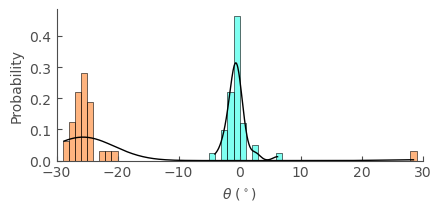

In [25]:
print('get misorientation plot')
file_name=files_df.iloc[files_df_idx]['file_name'][:-4]

filtered_df1=pd.read_pickle(dir_path+'/all grains/orientation/full/grain/'+str(files_df_idx)+'_'+str(file_name)+'_1.pkl')
filtered_df2=pd.read_pickle(dir_path+'/all grains/orientation/full/grain/'+str(files_df_idx)+'_'+str(file_name)+'_2.pkl')
fig=plt.figure(figsize=(12*1/2.54,5**1/2.54))
ax=fig.add_subplot(111)

# sns.histplot(orientation_combined,bins=bins,ax=ax,color='black',kde=True,line_kws=dict(),kde_kws=dict(cut=10))
# sns.rugplot(orientation_combined,color='black')
# sns.scatter()
mean1=circmean(filtered_df1['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean1))  
# ax.hist(filtered_df1['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
sns.histplot(filtered_df1['node_ij_avg'],stat='probability',bins=np.arange(-30,31,1),ax=ax,color=color,alpha=0.5,kde=True,line_kws=dict(linewidth=1)) #,line_kws=dict(),kde_kws=dict(cut=10)
ax.lines[0].set_color('black')

mean2=circmean(filtered_df2['node_ij_avg'],low=-30,high=30)
norm=colors.Normalize(vmin=-30, vmax=30)
color=plt.cm.hsv(norm(mean2))  
# ax.hist(filtered_df2['node_ij_avg'],bins=np.arange(-30,31,1),color=color,alpha=0.5)
sns.histplot(filtered_df2['node_ij_avg'],stat='probability',bins=np.arange(-30,31,1),ax=ax,color=color,alpha=0.5,kde=True,line_kws=dict(linewidth=1)) #,line_kws=dict(),kde_kws=dict(cut=10)
ax.lines[1].set_color('black')

ax.set_xlim(-30,30)
# ax.set_ylim(0,np.max(data_df['band_width_um']))
ax.set_xlabel(r'$\theta$'+' ('+r'$^\circ)$')
ax.set_ylabel('Probability')
axis_color='0.3'
ax.tick_params(direction="in",colors=axis_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.xaxis.label.set_color(axis_color)
ax.yaxis.label.set_color(axis_color)

im_path=dir_path+'/all grains/orientation/full/grain/'+str(files_df_idx)+'_'+files_df.iloc[files_df_idx]['file_name'].split('.')[0]
plt.savefig(im_path+'.svg',bbox_inches='tight', pad_inches=0)    
plt.savefig(im_path+'.png',bbox_inches='tight', pad_inches=0)    
# plt.savefig(dir_path+'/all grains/bands/plots/bandwidth_vs_sectorangle.png')
# plt.savefig(dir_path+'/all grains/bands/plots/bandwidth_vs_sectorangle.svg')